SMOTE stands for Synthetic Minority Over-Sampling Technique, which creates synthetic examples for the minority class, for our example of binary classification it'll create synthetic data for our target feature which are the defeaulters of the next payments (IMG below). We'll use this as a way to balance the imbalanaced dataset and compare it to the imbalanced training done in "DS340_models.ipynb" and evaluate based on the same metrics.

Doc: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

![Fin](targetdistribution.png "")

In [1]:
!pip install xgboost
!brew install libomp
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Download dataset
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

⠋ JSON API formula.jws.json                        [Downloading  31.7MB/-------]
⠋ JSON API cask.jws.json                           [Downloading  15.0MB/-------]⠋ JSON API formula.jws.json                        [Downloading  31.7MB/-------]
⠋ JSON API cask.jws.json                           [Downloading  15.0MB/-------]⠙ JSON API formula.jws.json                        [Downloading 413.7KB/-------]
⠙ JSON API cask.jws.json                           [Downloading 258.0KB/-------]⠙ JSON API formula.jws.json                        [Downloading   2.4MB/-------]
⠙ JSON API cask.jws.json                           [Downloading   1.8MB/-------]⠚ JSON API formula.jws.json                        [Downloading   4.9MB/-------]
⠚ JSON API cask.jws.json                           [Downloading   4.2MB/-------]⠚ JSON API formula.jws.json                        [Downloading   8.7MB/-------]
⠚ JSON API cask.jws.json                           [Downloading   8.7MB/-------]⠞ JSON API formula.jws.json       

/Users/popthrop/Desktop/DS 340/Final Project/DS340/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using two different "training data" to balance our target

In [ ]:


# CSV file in the downloaded directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

df = pd.read_csv(csv_file)

target_vec = df['default.payment.next.month']
feature_vec = df.drop(['default.payment.next.month','ID'], axis=1)

Helper Functions

In [3]:


def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    #Evaluations of all models will be based on AUC Score, Precision, Recall, and F score

    precision, recall, fscore, _ = precision_recall_fscore_support(y_test,y_pred)

    print(f'AUC Score: {model.score(x_test,y_test)} \nPrecision: {precision} \nRecall: {recall} \n \
    F Score: {fscore}')

def evaluate_features(model,x_test,y_test,title):

    result = permutation_importance(model, x_test, y_test, n_repeats=15)
    importances = result.importances_mean
    feature_names = feature_vec.columns

    sorted = np.argsort(importances)[::-1] 

    sorted_features = feature_names[sorted]
    sorted_importances = importances[sorted]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_features, sorted_importances)
    plt.xticks(rotation=90)
    plt.ylabel("Permutation Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(feature_vec, target_vec, train_size=0.8 \
                                                    ,random_state=10)

Baseline Model of Logistic Regression with Cross Validation

AUC Score: 0.697971191295808 
Precision: [0.85696073 0.36381136] 
Recall: [0.71770233 0.57403189] 
     F Score: [0.78117374 0.44536082]


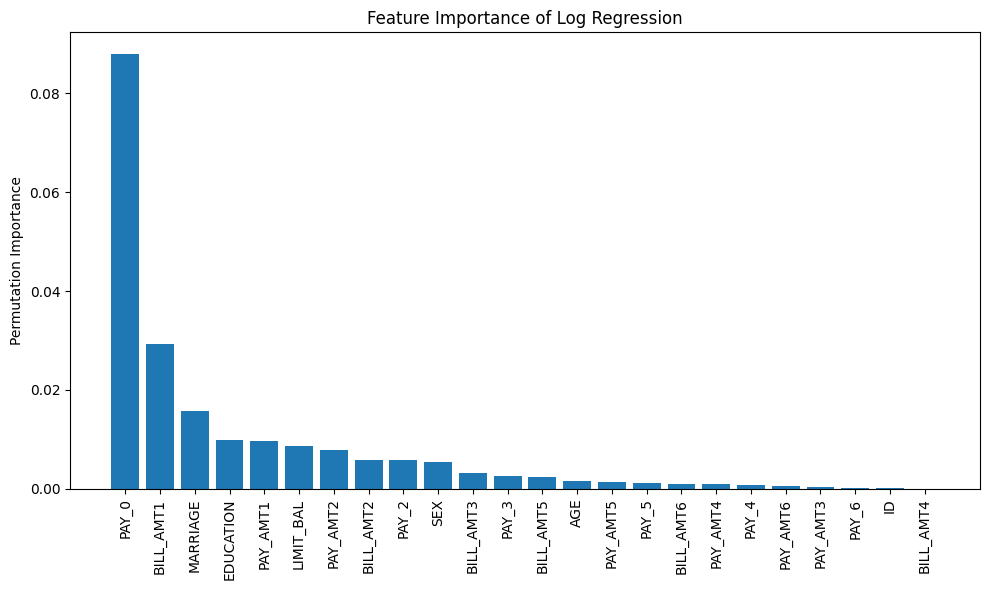

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

LR_base = Pipeline([
    ('smote', SMOTE(random_state=50)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegressionCV(
        cv=5,
        scoring='roc_auc',
        max_iter=5000,
        class_weight='balanced',
        solver="lbfgs",
        n_jobs=-1

    ))
])

title = 'Feature Importance of Log Regression'
evaluate_model(LR_base,x_train,y_train,x_test,y_test)
evaluate_features(LR_base,x_test,y_test,title)

Start to code more advanced ML techniques 

AUC Score: 0.7583271436402789 
Precision: [0.86054777 0.53410025] 
Recall: [0.87892377 0.49354594] 
     F Score: [0.86963871 0.51302289]


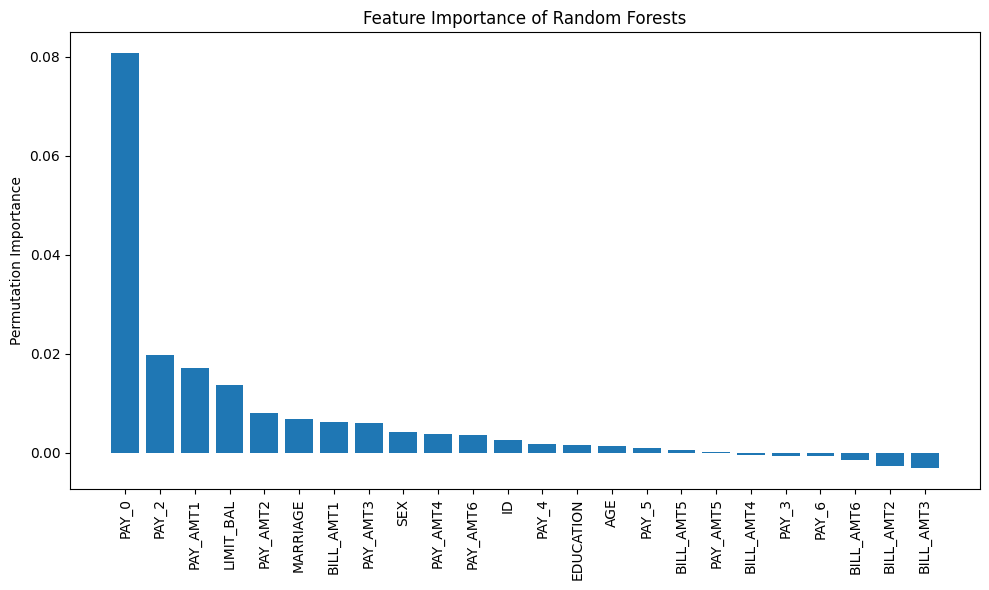

In [6]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameter_grid = {'RF__n_estimators': [10,100,200,500,1000]}

RF = Pipeline([
    ('smote', SMOTE(random_state=50)),
    ('RF', RandomForestClassifier(n_jobs=-1))
    ])

RF_gridsearch = GridSearchCV(RF,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of Random Forests'
evaluate_model(RF_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(RF_gridsearch,x_test,y_test,title)


AUC Score: 0.7620125039095998 
Precision: [0.86788708 0.48976808] 
Recall: [0.84027333 0.54517844] 
     F Score: [0.853857   0.51598994]


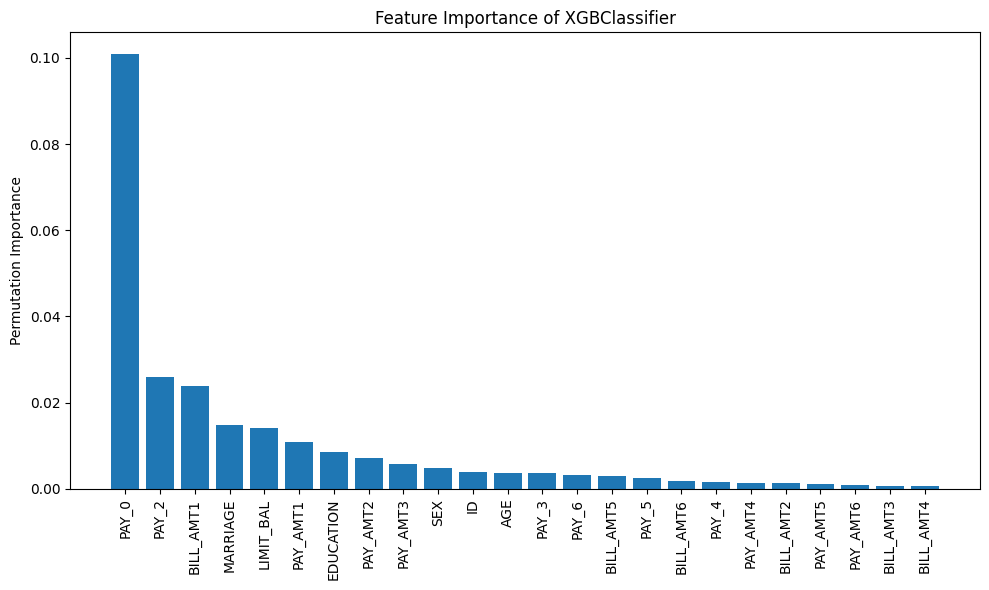

In [8]:
from xgboost import XGBClassifier

parameter_grid = {'XGB__n_estimators': [100,200,500],'XGB__max_depth': [3,5], 'XGB__learning_rate': [0.01,0.05,0.1]}

xgb = Pipeline([
    ('smote', SMOTE(random_state=50)),
    ('XGB', XGBClassifier(verbosity=0,n_jobs=-1))
    ])

xgb_gridsearch = GridSearchCV(xgb,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of XGBClassifier'
evaluate_model(xgb_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(xgb_gridsearch,x_test,y_test,title)

AUC Score: 0.7651124578456365 
Precision: [0.86523438 0.5       ] 
Recall: [0.85137732 0.5284738 ] 
     F Score: [0.85824992 0.51384275]


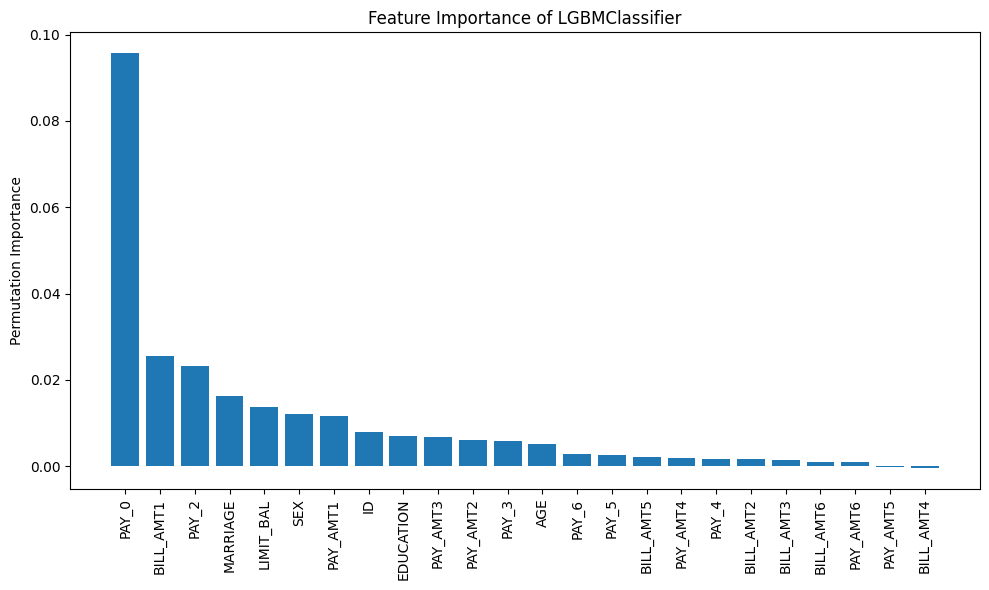

In [12]:
from lightgbm import LGBMClassifier

parameter_grid = {'LGMB__n_estimators': [100,200,500,1000],'LGMB__max_depth': [3,5,-1], 'LGMB__learning_rate': [0.01,0.05,0.1]}
LGBM = Pipeline([
    ('smote', SMOTE(random_state=50)),
    ('LGMB', LGBMClassifier(verbosity=-1, n_jobs=-1))
    ])
LGBM_gridsearch = GridSearchCV(LGBM,param_grid=parameter_grid,scoring='roc_auc',cv=5,n_jobs=-1)

title = 'Feature Importance of LGBMClassifier'
evaluate_model(LGBM_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(LGBM_gridsearch,x_test,y_test,title)